# Neural Networks Learing

## 1. Neural Networks

### 1.1 visualizing the data

借助Scipy提供的函数，读取.mat文件

In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [83]:
data = loadmat('ex4data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [84]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

In [85]:
# 绘图
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))
    
    sample_index = np.random.choice(np.arange(X.shape[0]), 100)
    samples = X[sample_index, :]
    
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8, 8))
    
    for i in range(10):
        for j in range(10):
            ax[i][j].matshow(samples[10 * i + j].reshape((size, size)), cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

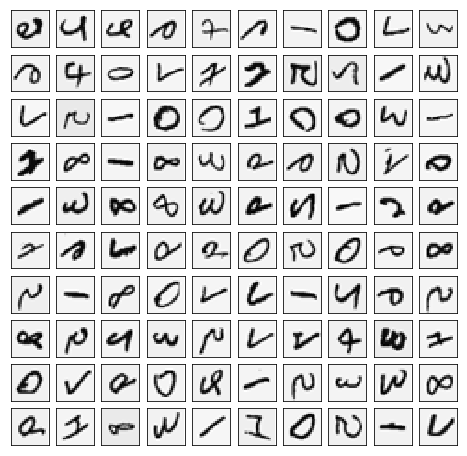

In [7]:
plot_100_image(X)

### 1.2 model representation

读取权重

In [86]:
weights = loadmat('ex4weights.mat')
weights

{'Theta1': array([[ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
          -1.30529929e-05,  -5.04175101e-06,   2.80464449e-09],
        [ -9.83811294e-02,   7.66168682e-09,  -9.75873689e-09, ...,
          -5.60134007e-05,   2.00940969e-07,   3.54422854e-09],
        [  1.16156052e-01,  -8.77654466e-09,   8.16037764e-09, ...,
          -1.20951657e-04,  -2.33669661e-06,  -7.50668099e-09],
        ..., 
        [ -1.83220638e-01,  -8.89272060e-09,  -9.81968100e-09, ...,
           2.35311186e-05,  -3.25484493e-06,   9.02499060e-09],
        [ -7.02096331e-01,   3.05178374e-10,   2.56061008e-09, ...,
          -8.61759744e-04,   9.43449909e-05,   3.83761998e-09],
        [ -3.50933229e-01,   8.85876862e-09,  -6.57515140e-10, ...,
          -1.80365926e-06,  -8.14464807e-06,   8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.05778129,
         -2.20823629,  0.56383834,  1.21105294,  2.21030997,  0.44456156,
         -1.18244872,  1

In [12]:
theta1 = weights['Theta1']
theta2 = weights['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

#### unrolling parameters

In [13]:
theta = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
theta.shape # 25 * 401 + 10 * 26

(10285,)

#### X和y的预处理

In [87]:
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
X.shape

(5000, 401)

> 对于标签y要进行one-hot编码

其实就是将分类变量转换为“哑变量矩阵”

In [88]:
def one_hot(y, size):
    res = []
    for i in y:
        y_array = np.zeros(size)
        y_array[i - 1] = 1
        
        res.append(y_array)
    return np.array(res)
y = one_hot(y, 10)
y

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### 1.3 feedward and cost function

Sigmoid函数: 

$g\left( z\right) =\dfrac {1}{1+e^{-z}}$   

$h_{\theta }\left( x\right) =\dfrac {1}{1+e^{-\theta x}}$

In [89]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

前向传播

In [90]:
def feed_forward(X, theta):
    # reshape the parameters
    theta1 = theta[:25 * 401].reshape(25, 401)
    theta2 = theta[25 * 401:].reshape(10, 26)
    
    # computer cost
    a1 = X
    
    z2 = np.dot(a1, theta1.T)
    a2 = np.insert(sigmoid(z2), 0, np.ones(z2.shape[0]), axis=1) # add bias
    
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [14]:
_, _, _, _, h = feed_forward(X, theta)
h.shape

(5000, 10)

cost function(无正则化): $J(\theta) = - \frac{1}{m} \sum_{i=1}^m [ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))]$

In [91]:
def cost(X, y, theta):
    m = X.shape[0]
    
    _, _, _, _, h = feed_forward(X, theta)
    first = y * np.log(h)
    second = (1 - y) * np.log(1 - h)
    return -np.sum(first + second) / m

In [16]:
cost(X, y, theta)

0.28762916516131892

### 1.4 regularized cost function

cost function: $\begin{gather*} J(\Theta) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left[y^{(i)}_k \log ((h_\Theta (x^{(i)}))_k) + (1 - y^{(i)}_k)\log (1 - (h_\Theta(x^{(i)}))_k)\right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1} \sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} ( \Theta_{j,i}^{(l)})^2\end{gather*}$

In [92]:
def regularized_cost(X, y, theta, learing_rate=1):
    # reshape parameters
    theta1 = theta[:25 * 401].reshape(25, 401)
    theta2 = theta[25 * 401:].reshape(10, 26)
    m = X.shape[0]
    
    # computer feed_forward
    a1, z2, a2, z2, h = feed_forward(X, theta)
    
    # computer cost
    J = cost(X, y, theta)
    
    # add regularized parameters
    reg1 = np.sum(np.power(theta1[:, 1:], 2)) # ignore the first
    reg2 = np.sum(np.power(theta2[:, 1:], 2))
    J += learing_rate / (2 * m) * (reg1 + reg2)
    
    return J

In [18]:
regilarized_cost(X, y, theta)

0.38376985909092365

## 2. Backpropagation

### 2.1 sigmoid gradient

对sigmoid函数求导，得到：$g'\left( z\right) =g\left( z\right) \left( 1-g\left( z\right) \right)
$

In [93]:
def sigmoid_gradient(x):
    g = sigmoid(x)
    return g * (1 - g)

### 2.2 random initialization

对于神经网络而言，初始权值需要初始化，使用随机的方式
$\varepsilon =\dfrac {\sqrt {6}}{\sqrt {lin+lout}}$

In [94]:
def random_init(in_size, out_size):
    epsilon = np.sqrt(6 / (in_size + out_size))
    weights = np.random.rand(in_size, out_size) * 2 * epsilon - epsilon
    return weights

In [95]:
theta1 = random_init(25, 401)
theta2 = random_init(10, 26)
theta = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
theta1.shape, theta2.shape, theta.shape

((25, 401), (10, 26), (10285,))

### 2.3 backpropagation

先是没有正则项的

In [96]:
def backpro(X, y, theta):
     # reshape parameters
    theta1 = theta[:25 * 401].reshape(25, 401)
    theta2 = theta[25 * 401:].reshape(10, 26)
    m = X.shape[0]
    
    # computer feed forward
    a1, z2, a2, z3, h = feed_forward(X, theta)
    
    # perform backpropagation
    for i in range(m):
        a1i = a1[i, :] # (1, 401)
        z2i = z2[i, :] # (1, 25)
        a2i = a2[i, :] # (1, 26)
        
        hi = h[i, :] # (1, 10)
        yi = y[i, :] # (1, 10)
        
        d3i = hi - yi # (1, 10)
        
        z2i = np.insert(z2i, 0, np.ones(1)) # (1, 26)
        d2i = np.dot(theta2.T, d3i) * sigmoid_gradient(z2i) # (1, 26)
        
        theta2 += np.mat(d3i).T * np.mat(a2i) # (1, 10).T * (1, 26) -> (10, 26)
        theta1 += np.mat(d2i[1:]).T * np.mat(a1i) # (1, 25).T * (1, 401) ->(25, 401)
    
    theta1 /= m
    theta2 /= m
    
    theta = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
    
    return theta

In [73]:
theta = backpro(X, y, theta)
theta.shape

(10285,)

有正则项的

In [97]:
def backpro_regularized(X, y, theta, l=1):
    # reshape parameters
    m = X.shape[0]
    d = backpro(X, y, theta)
    d1 = d[:25 * 401].reshape(25, 401)
    d2 = d[25 * 401:].reshape(10, 26)
    theta1 = theta[:25 * 401].reshape(25, 401)
    theta2 = theta[25 * 401:].reshape(10, 26)
    
    
    theta1[:, 0] = 0
    d1 += l * theta1 / m
    
    theta2[:, 0] = 0
    d2 += l * theta2 / m
    
    d = np.concatenate((np.ravel(d1), np.ravel(d2)))
    
    return d

In [71]:
d = backpro_regularized(X, y, theta)
d.shape

(10285,)

### 2.4 gradient checking

公式如下：$f_{i}\left( \theta \right) \approx \dfrac {J\left( \theta ^{\left( i+\right) }\right) -J\left( \theta ^{i-1}\right) }{2\varepsilon }$

In [98]:
def numeric_gradient(X, y, plus, minus, epsilon, regularized=False):
    # calculate partial gradient
    if regularized:
        return (regilarized_cost(X, y, plus) - regularized_cost(X, y, plus)) / (2 * epsilon)
    else:
        return (cost(X, y, plus) - cost(X, y, minus)) / (2 * epsilon)

In [99]:
def expand_array(arr):
    """
    replicate array into matrix
    
    [1, 2, 3] ->
    [[1, 2, 3],
    [1, 2, 3],
    [1, 2, 3]]
    """
    m = arr.shape[0]
    return np.array(np.mat(np.ones((m, 1))) * np.mat(arr)) 

In [104]:
def gradient_checking(X, y, theta, epsilon, regularized=False):
    # parse parameters
    theta_matrix = expand_array(theta)
    epsilon_matrix = np.identity(len(theta)) * epsilon
    
    plux_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    numeric_grad = np.array([numeric_gradient(X, y, plux_matrix[i], minus_matrix[i], epsilon, regularized) for i in range(len(theta))])
    
    analytical_grad = backpro_regularized(X, y, theta) if regularized else backpro(X, y, theta)
    
    # 这个地方有些疑惑
    diff = np.linalg.norm(numeric_grad - analytical_grad) / np.linalg.norm(numeric_grad + analytical_grad)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [103]:
gradient_checking(X, y, theta, epsilon=0.0001, regularized=True)
# 有些问题，之后处理

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 13.824260081106917



### 2.5 train the model

In [ ]:
from scipy.optimize import minimize

fmin = minimize(fun=regularized_cost,
                x0=theta,
               args=(X, y, 1),
               method='TNC',
               jac=regualarized_gradient,
               options={'maxiter': 400})
fmin

### 2.6 accuracy

In [ ]:
_, _, _, _, h = feed_forward(X, theta)
y_pred = np.argmax(h, axis=1) + 1
correct = [i if a == b else 0 for(a, b) in zip(y_pred, y)]
accuracy = sum(map(int, correct)) / len(correct)
accuracy

### 2.7 visualize hidden layers

In [ ]:
def plot_hidden_layer(theta):
    theta1 = theta[:25 * 401].reshape(25, 401)
    theta2 = theta[25 * 401:].reshape(10, 26)
    hidden_layer = theta1[:, 1:]
    
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(5, 5))
    
    for i in range(5):
        for j in range(5):
            ax[i, j].amtshow(hidden_layer[5 * i + j].reshape((20, 20)), cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))